In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import dalex as dx
import pickle as pkl 

In [8]:
df = pd.read_csv("../data/preprocessed_data.csv")

In [9]:
df.shape

(119210, 26)

In [10]:
X = df.drop(["is_canceled"], axis=1)
y = df["is_canceled"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score  

def evaluate(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(12.8, 4.8))
    plt.subplot(1, 2, 1)
    y_pred_train = model.predict(X_train)
    sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True)
    plt.title("Confusion matrix on train set")
    
    plt.subplot(1, 2, 2)
    y_pred_test = model.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)
    plt.title("Confusion matrix on test set")    
    
    plt.show()
    
    print("\nTrain set metrics")
    print('Accuracy: ', accuracy_score(y_train, y_pred_train))
    print('Precision: ', precision_score(y_train, y_pred_train))
    print('Recall: ', recall_score(y_train, y_pred_train))
    print('F1 score: ', f1_score(y_train, y_pred_train))
    

    print("\nTest set metrics")
    print('Accuracy: ', accuracy_score(y_test, y_pred_test))
    print('Precision: ', precision_score(y_test, y_pred_test))
    print('Recall: ', recall_score(y_test, y_pred_test))
    print('F1 score: ', f1_score(y_test, y_pred_test))

    gini_train_test(model, X_train, y_train, X_test, y_test)    


def plot_metrics(model, X_train, y_train, X_test, y_test):
    train_metrics = calculate_metrics(model, X_train, y_train, 'train')
    test_metrics = calculate_metrics(model, X_test, y_test, 'test')
    df = pd.concat([train_metrics, test_metrics])
    sns.barplot(data=df, x='metric', y='value', hue='dataset')
    plt.show()


def calculate_metrics(model, X, y, dataset_name):
    # util func returning a DF with metrics wrt model, dataset
    y_pred = model.predict(X)
    scores = [accuracy_score(y, y_pred), precision_score(y, y_pred), recall_score(y, y_pred), f1_score(y, y_pred)]
    return pd.DataFrame({'dataset': [dataset_name]*4,\
        'metric': ['accuracy', 'precision', 'recall', 'f1'], 'value': scores})

def gini_train_test(model, X_train, y_train, X_test, y_test):
        
    y_pred_proba = model.predict_proba(X_train)[::,1]
    fpr, tpr, _ = roc_curve(y_train,  y_pred_proba)
    roc_auc = auc(fpr, tpr)
    gini_train = (2 * roc_auc) - 1
    plt.plot(fpr, tpr, label=f'train (AUC = {roc_auc:.2f})')

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    roc_auc = auc(fpr, tpr)
    gini_test = (2 * roc_auc) - 1
    plt.plot(fpr, tpr, label=f'test (AUC = {roc_auc:.2f})')


    plt.plot([0, 1], [0, 1], "--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    print("Gini on train set: %.4f" % gini_train)    
    print("Gini on test set: %.4f" % gini_test)

    return

def show_metrics(model, X, y):
    """
    Prints out the most important metrics
    """ 
    y_pred = model.predict(X)
    
    sns.heatmap(confusion_matrix(y, y_pred), annot=True)
    plt.show()
    
    print('Accuracy: ', accuracy_score(y, y_pred))
    print('Precision: ', precision_score(y, y_pred))
    print('Recall: ', recall_score(y, y_pred))
    print('F1 score: ', f1_score(y, y_pred))


# Base models

In [7]:
names = ["logistic_regression", "svm",  "neural_network", "decision_tree", "random_forest", "xgb"]
models = []

for name in names:
    with open("../models/base/" + name, "rb") as file:
        models.append(pkl.load(file))

In [8]:
explainers = []

for model, name in zip(models, names):
    explainers.append(dx.Explainer(model, X_test, y_test, label=name))

performances = []

for explainer in explainers:
    performances.append(explainer.model_performance(model_type="classification").result)

performance = pd.concat(performances)
performance.sort_values(by="accuracy", ascending=False, inplace=True)

Preparation of a new explainer is initiated

  -> data              : 23842 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 23842 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : logistic_regression
  -> predict function  : <function yhat_proba_default at 0x000001AFFE9234C0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 1.4e-70, mean = 0.37, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.000929, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 23842 rows 26 cols
  -> target variable   : Parameter 'y' was a p

In [9]:
performance

,recall,precision,f1,accuracy,auc
random_forest,0.760633,0.859957,0.807251,0.865322,0.931445
xgb,0.704299,0.854047,0.771978,0.845734,0.913964
neural_network,0.726244,0.799303,0.761024,0.830887,0.900637
svm,0.633371,0.852337,0.726718,0.823379,0.783043
decision_tree,0.767195,0.757089,0.762108,0.822414,0.816973
logistic_regression,0.600452,0.843075,0.701374,0.810419,0.850828


logistic_regression


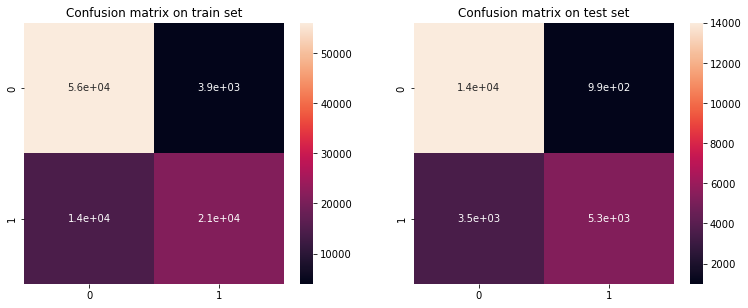

Train set metrics
Accuracy:  0.8086674775606073
Precision:  0.8421031587365054
Recall:  0.5956333606719647
F1 score:  0.6977422186883997

Test set metrics
Accuracy:  0.8104185890445432
Precision:  0.8430749682337992
Recall:  0.6004524886877828
F1 score:  0.7013742071881608


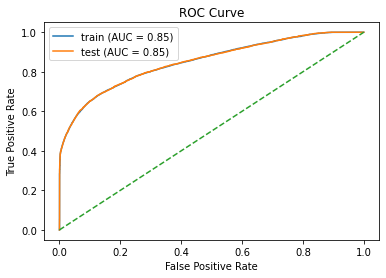

Gini on train set: 0.7014
Gini on test set: 0.7017
neural_network


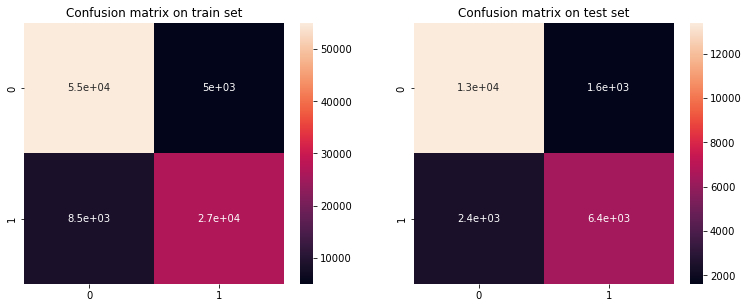

Train set metrics
Accuracy:  0.8583382266588373
Precision:  0.8430522845030617
Recall:  0.7592692101020957
F1 score:  0.7989702993869412

Test set metrics
Accuracy:  0.830886670581327
Precision:  0.7993027888446215
Recall:  0.7262443438914027
F1 score:  0.7610241820768137


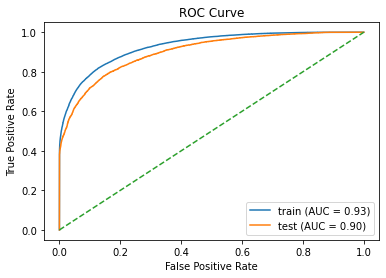

Gini on train set: 0.8585
Gini on test set: 0.8013
decision_tree


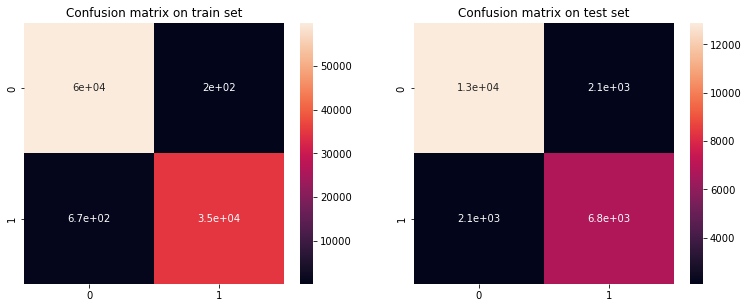

Train set metrics
Accuracy:  0.9908984145625367
Precision:  0.9943528737279633
Recall:  0.9810232189824373
F1 score:  0.9876430727179546

Test set metrics
Accuracy:  0.8242597097558929
Precision:  0.7622377622377622
Recall:  0.7644796380090497
F1 score:  0.7633570541059528


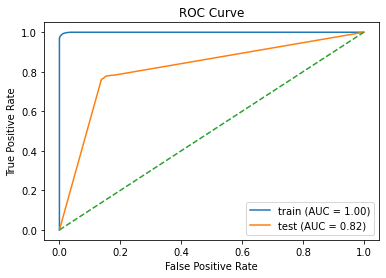

Gini on train set: 0.9995
Gini on test set: 0.6324
random_forest


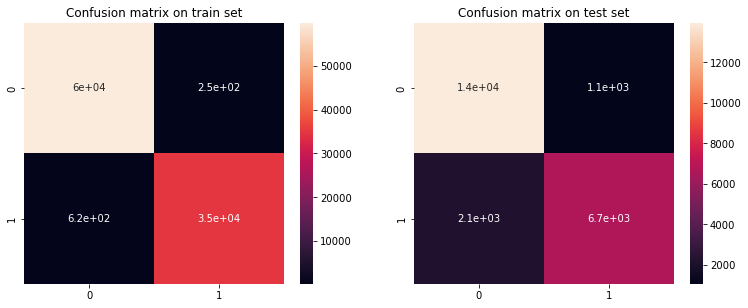

Train set metrics
Accuracy:  0.9908984145625367
Precision:  0.9927989712816117
Recall:  0.9825786928363359
F1 score:  0.9876623930409074

Test set metrics
Accuracy:  0.865447529569667
Precision:  0.8633548387096774
Recall:  0.7569004524886878
F1 score:  0.8066305003013864


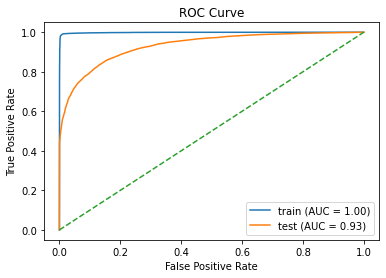

Gini on train set: 0.9974
Gini on test set: 0.8630
xgb


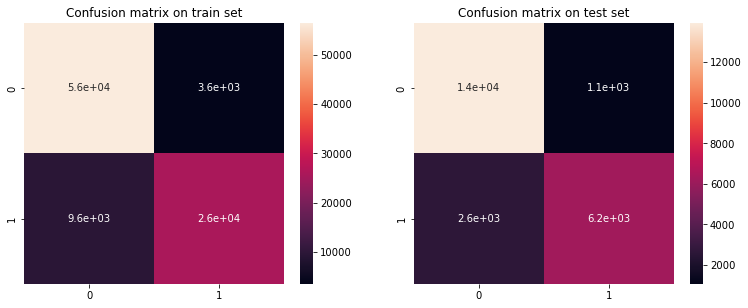

Train set metrics
Accuracy:  0.862186477644493
Precision:  0.8779516842463423
Recall:  0.7297434882208207
F1 score:  0.7970161701339018

Test set metrics
Accuracy:  0.8457344182535023
Precision:  0.8540466392318244
Recall:  0.7042986425339367
F1 score:  0.7719776813391197


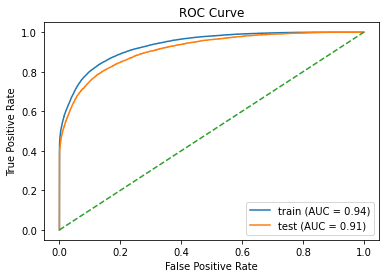

Gini on train set: 0.8707
Gini on test set: 0.8279


In [10]:
for model, name in zip(models, names):
    if name == "svm": continue
    print(name)
    evaluate(model, X_train, y_train, X_test, y_test)

# Tuned models

In [7]:
tuned_names = ["decision_tree", "random_forest", "xgb"]
tuned_models = []

for name in tuned_names:
    with open("../models/tuned/" + name, "rb") as file:
        tuned_models.append(pkl.load(file))

In [8]:
tuned_explainers = []

for model, name in zip(tuned_models, tuned_names):
    tuned_explainers.append(dx.Explainer(model, X_test, y_test, label=name))

tuned_performances = []

for explainer in tuned_explainers:
    tuned_performances.append(explainer.model_performance(model_type="classification").result)

tuned_performances = pd.concat(tuned_performances)
tuned_performances.sort_values(by="accuracy", ascending=False, inplace=True)

Preparation of a new explainer is initiated

  -> data              : 23842 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 23842 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : decision_tree
  -> predict function  : <function yhat_proba_default at 0x000001D9D1D09280> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.37, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.000983, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 23842 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. C

In [17]:
tuned_performances

,recall,precision,f1,accuracy,auc
random_forest,0.746606,0.870598,0.803849,0.864902,0.931721
xgb,0.764480,0.853391,0.806492,0.863980,0.930999
decision_tree,0.716063,0.832347,0.769839,0.841247,0.904393


decision_tree


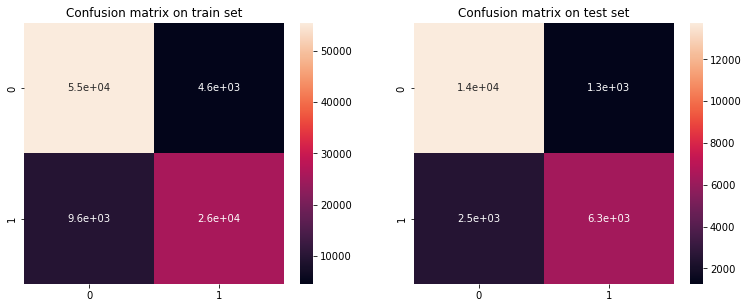

Train set metrics
Accuracy:  0.8513128093280765
Precision:  0.8491312518545383
Recall:  0.7283859837665092
F1 score:  0.7841376160755061

Test set metrics
Accuracy:  0.8412465397198222
Precision:  0.833047832388984
Recall:  0.715158371040724
F1 score:  0.7696147057033295


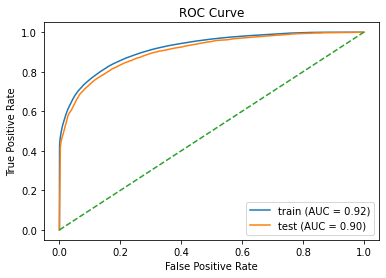

Gini on train set: 0.8384
Gini on test set: 0.8087
random_forest


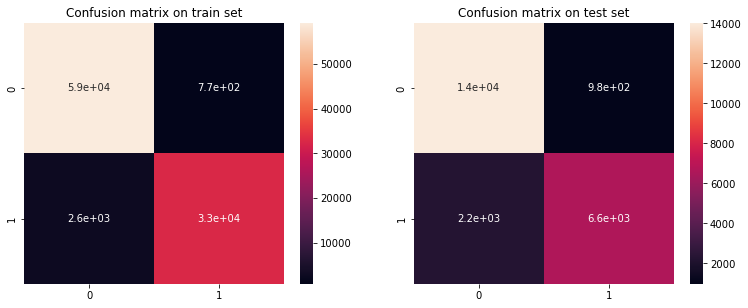

Train set metrics
Accuracy:  0.9643066856807315
Precision:  0.9770114942528736
Recall:  0.925506943069657
F1 score:  0.9505620588491591

Test set metrics
Accuracy:  0.8649022732992199
Precision:  0.8705975464978235
Recall:  0.746606334841629
F1 score:  0.803848730284392


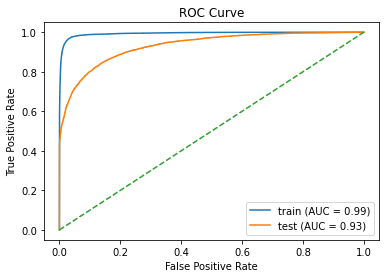

Gini on train set: 0.9875
Gini on test set: 0.8635
xgb


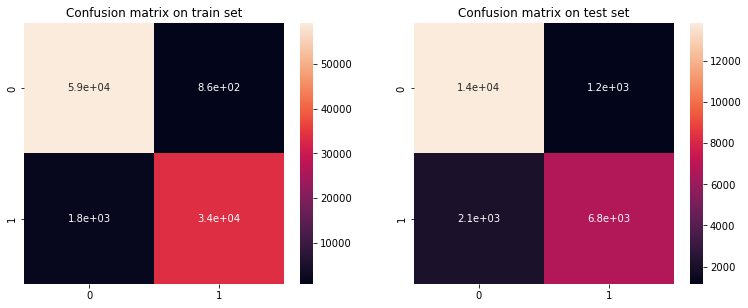

Train set metrics
Accuracy:  0.9724016441573693
Precision:  0.975061692553346
Recall:  0.9498571792188694
F1 score:  0.9622944243882874

Test set metrics
Accuracy:  0.8639795319184632
Precision:  0.8533905796186387
Recall:  0.7644796380090497
F1 score:  0.8064920341309146


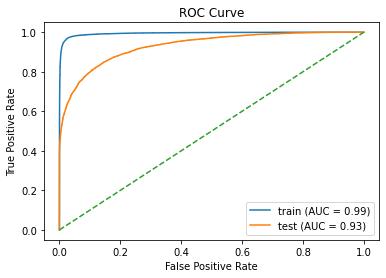

Gini on train set: 0.9893
Gini on test set: 0.8620


In [18]:
for model, name in zip(tuned_models, tuned_names):
    print(name)
    evaluate(model, X_train, y_train, X_test, y_test)

# Preventing overfitting

In [19]:
no_names = ["random_forest", "xgb"]
no_models = []

for name in no_names:
    with open("../models/not-overfited/" + name, "rb") as file:
        no_models.append(pkl.load(file))

In [21]:
no_explainers = []

for model, name in zip(no_models, no_names):
    no_explainers.append(dx.Explainer(model, X_test, y_test, label=name))

no_performances = []

for explainer in no_explainers:
    no_performances.append(explainer.model_performance(model_type="classification").result)

no_performances = pd.concat(no_performances)
no_performances.sort_values(by="accuracy", ascending=False, inplace=True)


Preparation of a new explainer is initiated

  -> data              : 23842 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 23842 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : random_forest
  -> predict function  : <function yhat_proba_default at 0x000001AFFE9234C0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00761, mean = 0.371, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.781, mean = 0.000114, max = 0.965
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 23842 rows 26 cols
  -> target variable   : Parameter 'y' was a pand

random_forest


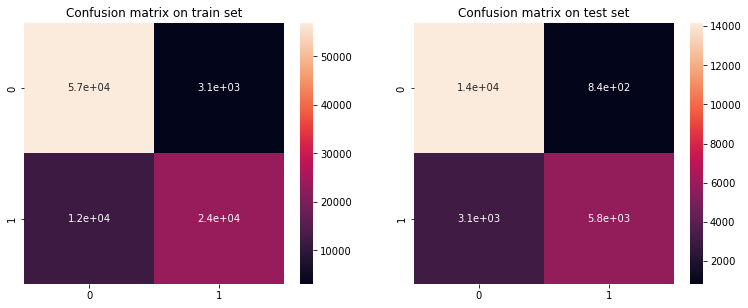

Train set metrics
Accuracy:  0.843469507591645
Precision:  0.8842580402482603
Recall:  0.6648378064990526
F1 score:  0.7590081363812475

Test set metrics
Accuracy:  0.8354164919050415
Precision:  0.8727631179860479
Recall:  0.6510180995475113
F1 score:  0.7457561228456654


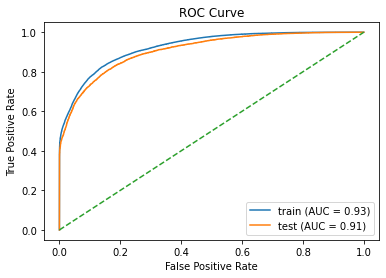

Gini on train set: 0.8513
Gini on test set: 0.8182
xgb


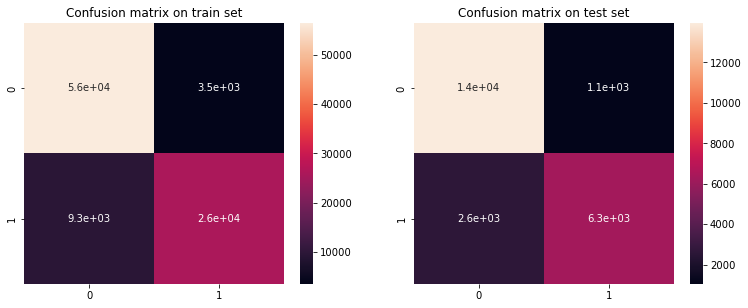

Train set metrics
Accuracy:  0.8654685009646842
Precision:  0.8810337245881676
Recall:  0.7366158545207726
F1 score:  0.8023782385015865

Test set metrics
Accuracy:  0.8474540726449123
Precision:  0.8561259411362081
Recall:  0.7074660633484163
F1 score:  0.7747290182719109


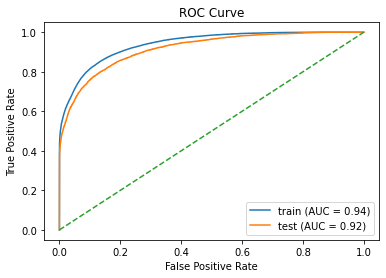

Gini on train set: 0.8810
Gini on test set: 0.8344


In [22]:
for model, name in zip(no_models, no_names):
    print(name)
    evaluate(model, X_train, y_train, X_test, y_test)